<a href="https://colab.research.google.com/github/victormurcia/VCHAMPS/blob/main/VCHAMPS_Outcome_Variables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#General utilities
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Import tqdm for the progress bar
import glob,shutil,os,warnings,math,time,sys,re
from typing import List
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

#For performing UTC normalization on datetime columns based on the STATE column
import pytz

#For Slider viz
import ipywidgets as widgets
from IPython.display import display, clear_output,HTML

#Enable data to be extracted and downloaded from my Google Drive
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Specify the path to the desired directory
directory_path = r'/content/drive/MyDrive/VCHAMPS - Train Cleaned'

# Change the current working directory to the desired directory
os.chdir(directory_path)

# Verify the current working directory
cwd = os.getcwd()

print(f"Current working directory: {cwd}")

Current working directory: /content/drive/MyDrive/VCHAMPS - Train Cleaned


In [11]:
#Load the Dataframes
ed_visits_df            = dd.read_parquet('/content/drive/MyDrive/VCHAMPS - Train Cleaned-Mapped/ed_visits.parquet')
inpatient_admissions_df = dd.read_parquet('/content/drive/MyDrive/VCHAMPS - Train Cleaned-Mapped/inpatient_admissions.parquet')
outpatient_visits_df    = dd.read_parquet('/content/drive/MyDrive/VCHAMPS - Train Cleaned-Mapped/outpatient_visits.parquet')

ed_visits_df = ed_visits_df.compute()
inpatient_admissions_df = inpatient_admissions_df.compute()
outpatient_visits_df = outpatient_visits_df.compute()

# Outcome Mortality Inhospital All  Cause
I simply rename the column to the desired var name since I had already recoded it before

In [15]:
inpatient_admissions_df.rename(columns={"Died during admission": "mortality_inhosp_allcause"}, inplace=True)

In [23]:
inpatient_admissions_df

,Internalpatientid,Age at admission,Admission date,Discharge date,Admitting unit service,Discharging unit service,Admitting specialty,Discharging specialty,mortality_inhosp_allcause,Outpatientreferralflag,...,cc Status_CC,cc Status_MCC,cc Status_NCC,Discharge disposition_Death with autopsy,Discharge disposition_Death without autopsy,Discharge disposition_Irregular,Discharge disposition_NBC or while ASIH,Discharge disposition_Regular,Discharge disposition_Transfer,Encounter ID
0,10,66,2015-11-28 17:41:09,2015-11-29 01:43:14,NON-COUNT,NON-COUNT,DRUG DEPENDENCE TRMT UNIT,MEDICAL OBSERVATION,0,0,...,0,1,0,0,0,0,0,1,0,974dbd04-1e56-59c6-a720-b8784dc604b2
1,10,66,2015-11-28 17:41:09,2015-11-29 01:43:14,NON-COUNT,NON-COUNT,DRUG DEPENDENCE TRMT UNIT,MEDICAL OBSERVATION,0,0,...,0,0,1,0,0,0,0,1,0,974dbd04-1e56-59c6-a720-b8784dc604b2
2,100001,84,2009-10-01 21:19:50,2009-10-04 16:51:33,MEDICINE,MEDICINE,PSYCHIATRIC MENTALLY INFIRM,GENERAL(ACUTE MEDICINE),0,1,...,0,1,0,0,0,0,0,1,0,c86658fc-cb34-536f-bf7c-a6a05ad131cc
3,100001,84,2009-10-01 21:19:50,2009-10-04 16:51:33,MEDICINE,MEDICINE,PSYCHIATRIC MENTALLY INFIRM,GENERAL(ACUTE MEDICINE),0,1,...,0,0,1,0,0,0,0,1,0,c86658fc-cb34-536f-bf7c-a6a05ad131cc
4,100001,85,2010-11-10 04:32:39,2010-11-19 08:49:45,SURGERY,SURGERY,SUBSTANCE ABUSE RES TRMT PROG,ORTHOPEDIC,0,0,...,0,0,1,0,0,0,0,1,0,9b0880c7-906a-5869-9bbb-698c6183bdec
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085813,99975,89,2018-01-05 00:59:05,2018-01-06 23:18:39,NON-COUNT,NON-COUNT,PODIATRY,MEDICAL OBSERVATION,0,0,...,0,0,1,0,0,0,0,1,0,95223157-498c-5de5-a061-13d1e9ae985a
1085814,99986,73,2019-06-26 19:47:10,2019-06-29 21:18:00,MEDICINE,MEDICINE,INTERMEDIATE MEDICINE,GENERAL(ACUTE MEDICINE),0,1,...,0,0,1,0,0,0,0,1,0,bd343752-5059-5181-81ad-dd066c9179c3
1085815,99986,73,2019-06-26 19:47:10,2019-06-29 21:18:00,MEDICINE,MEDICINE,INTERMEDIATE MEDICINE,GENERAL(ACUTE MEDICINE),0,1,...,0,0,1,0,0,0,0,1,0,bd343752-5059-5181-81ad-dd066c9179c3
1085816,99994,83,2016-08-13 20:09:52,2016-08-15 16:43:07,SURGERY,MEDICINE,INTERMEDIATE MEDICINE,GENERAL(ACUTE MEDICINE),0,1,...,1,0,0,0,0,0,0,1,0,a0b6452b-5012-5b06-81f3-150b3a92b656


In [40]:
inpatient_admissions_df['Internalpatientid'].nunique()

82318

# Hospital Readmissions
To figure out which patients have more than one encounter present I'll simply get the counts for each patient.

In [31]:
counts_df = inpatient_admissions_df.groupby(['Internalpatientid', 'Admission date', 'Discharge date']).size().reset_index(name='Count')
counts_df

,Internalpatientid,Admission date,Discharge date,Count
0,1,2011-12-10 18:28:02,2011-12-14 18:23:17,2
1,1,2012-08-10 23:27:47,2012-08-14 20:57:06,2
2,1,2016-07-16 15:18:16,2016-07-22 21:36:24,2
3,1,2022-12-31 05:41:51,2023-01-01 23:06:30,2
4,2,2009-09-30 11:42:00,2009-10-01 06:33:38,2
...,...,...,...,...
494373,169062,2005-02-24 11:52:16,2005-03-17 07:14:14,2
494374,169062,2005-03-17 06:48:07,2005-04-29 10:02:03,2
494375,169062,2005-05-17 11:24:53,2005-05-19 03:28:31,2
494376,169062,2005-06-01 02:09:21,2005-06-04 03:34:07,2


In [32]:
counts_df['Count'].value_counts()

2     439926
1      24452
3      23513
4       6173
5        222
9         38
7         22
6         21
8          8
10         2
12         1
Name: Count, dtype: int64

In [39]:
aggregated_counts_df = counts_df.groupby('Internalpatientid')['Count'].sum()
aggregated_counts_df = aggregated_counts_df.to_frame().reset_index()
aggregated_counts_df

,Internalpatientid,Count
0,1,8
1,2,39
2,3,2
3,4,2
4,5,3
...,...,...
82313,169055,2
82314,169057,58
82315,169060,15
82316,169062,18


In [53]:
aggregated_counts_df.describe()

,Internalpatientid,Count
count,82318.000000,82318.000000
mean,84394.798355,12.164569
std,48819.504133,13.896650
min,1.000000,1.000000
25%,42110.250000,4.000000
50%,84442.000000,8.000000
75%,126613.500000,16.000000
max,169064.000000,373.000000


In [47]:
merged_df = inpatient_admissions_df.merge(aggregated_counts_df, on='Internalpatientid', how='left')
merged_df.rename(columns={"Count": "rehosp_allcause"}, inplace=True)
merged_df

,Internalpatientid,Age at admission,Admission date,Discharge date,Admitting unit service,Discharging unit service,Admitting specialty,Discharging specialty,mortality_inhosp_allcause,Outpatientreferralflag,...,cc Status_MCC,cc Status_NCC,Discharge disposition_Death with autopsy,Discharge disposition_Death without autopsy,Discharge disposition_Irregular,Discharge disposition_NBC or while ASIH,Discharge disposition_Regular,Discharge disposition_Transfer,Encounter ID,rehosp_allcause
0,10,66,2015-11-28 17:41:09,2015-11-29 01:43:14,NON-COUNT,NON-COUNT,DRUG DEPENDENCE TRMT UNIT,MEDICAL OBSERVATION,0,0,...,1,0,0,0,0,0,1,0,974dbd04-1e56-59c6-a720-b8784dc604b2,2
1,10,66,2015-11-28 17:41:09,2015-11-29 01:43:14,NON-COUNT,NON-COUNT,DRUG DEPENDENCE TRMT UNIT,MEDICAL OBSERVATION,0,0,...,0,1,0,0,0,0,1,0,974dbd04-1e56-59c6-a720-b8784dc604b2,2
2,100001,84,2009-10-01 21:19:50,2009-10-04 16:51:33,MEDICINE,MEDICINE,PSYCHIATRIC MENTALLY INFIRM,GENERAL(ACUTE MEDICINE),0,1,...,1,0,0,0,0,0,1,0,c86658fc-cb34-536f-bf7c-a6a05ad131cc,16
3,100001,84,2009-10-01 21:19:50,2009-10-04 16:51:33,MEDICINE,MEDICINE,PSYCHIATRIC MENTALLY INFIRM,GENERAL(ACUTE MEDICINE),0,1,...,0,1,0,0,0,0,1,0,c86658fc-cb34-536f-bf7c-a6a05ad131cc,16
4,100001,85,2010-11-10 04:32:39,2010-11-19 08:49:45,SURGERY,SURGERY,SUBSTANCE ABUSE RES TRMT PROG,ORTHOPEDIC,0,0,...,0,1,0,0,0,0,1,0,9b0880c7-906a-5869-9bbb-698c6183bdec,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001358,99975,89,2018-01-05 00:59:05,2018-01-06 23:18:39,NON-COUNT,NON-COUNT,PODIATRY,MEDICAL OBSERVATION,0,0,...,0,1,0,0,0,0,1,0,95223157-498c-5de5-a061-13d1e9ae985a,8
1001359,99986,73,2019-06-26 19:47:10,2019-06-29 21:18:00,MEDICINE,MEDICINE,INTERMEDIATE MEDICINE,GENERAL(ACUTE MEDICINE),0,1,...,0,1,0,0,0,0,1,0,bd343752-5059-5181-81ad-dd066c9179c3,15
1001360,99986,73,2019-06-26 19:47:10,2019-06-29 21:18:00,MEDICINE,MEDICINE,INTERMEDIATE MEDICINE,GENERAL(ACUTE MEDICINE),0,1,...,0,1,0,0,0,0,1,0,bd343752-5059-5181-81ad-dd066c9179c3,15
1001361,99994,83,2016-08-13 20:09:52,2016-08-15 16:43:07,SURGERY,MEDICINE,INTERMEDIATE MEDICINE,GENERAL(ACUTE MEDICINE),0,1,...,0,0,0,0,0,0,1,0,a0b6452b-5012-5b06-81f3-150b3a92b656,14


In [59]:
merged_df['rehosp_allcause'] = np.where(merged_df['rehosp_allcause'] > 1, 1, 0)
merged_df

,Internalpatientid,Age at admission,Admission date,Discharge date,Admitting unit service,Discharging unit service,Admitting specialty,Discharging specialty,mortality_inhosp_allcause,Outpatientreferralflag,...,cc Status_MCC,cc Status_NCC,Discharge disposition_Death with autopsy,Discharge disposition_Death without autopsy,Discharge disposition_Irregular,Discharge disposition_NBC or while ASIH,Discharge disposition_Regular,Discharge disposition_Transfer,Encounter ID,rehosp_allcause
0,10,66,2015-11-28 17:41:09,2015-11-29 01:43:14,NON-COUNT,NON-COUNT,DRUG DEPENDENCE TRMT UNIT,MEDICAL OBSERVATION,0,0,...,1,0,0,0,0,0,1,0,974dbd04-1e56-59c6-a720-b8784dc604b2,1
1,10,66,2015-11-28 17:41:09,2015-11-29 01:43:14,NON-COUNT,NON-COUNT,DRUG DEPENDENCE TRMT UNIT,MEDICAL OBSERVATION,0,0,...,0,1,0,0,0,0,1,0,974dbd04-1e56-59c6-a720-b8784dc604b2,1
2,100001,84,2009-10-01 21:19:50,2009-10-04 16:51:33,MEDICINE,MEDICINE,PSYCHIATRIC MENTALLY INFIRM,GENERAL(ACUTE MEDICINE),0,1,...,1,0,0,0,0,0,1,0,c86658fc-cb34-536f-bf7c-a6a05ad131cc,1
3,100001,84,2009-10-01 21:19:50,2009-10-04 16:51:33,MEDICINE,MEDICINE,PSYCHIATRIC MENTALLY INFIRM,GENERAL(ACUTE MEDICINE),0,1,...,0,1,0,0,0,0,1,0,c86658fc-cb34-536f-bf7c-a6a05ad131cc,1
4,100001,85,2010-11-10 04:32:39,2010-11-19 08:49:45,SURGERY,SURGERY,SUBSTANCE ABUSE RES TRMT PROG,ORTHOPEDIC,0,0,...,0,1,0,0,0,0,1,0,9b0880c7-906a-5869-9bbb-698c6183bdec,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001358,99975,89,2018-01-05 00:59:05,2018-01-06 23:18:39,NON-COUNT,NON-COUNT,PODIATRY,MEDICAL OBSERVATION,0,0,...,0,1,0,0,0,0,1,0,95223157-498c-5de5-a061-13d1e9ae985a,1
1001359,99986,73,2019-06-26 19:47:10,2019-06-29 21:18:00,MEDICINE,MEDICINE,INTERMEDIATE MEDICINE,GENERAL(ACUTE MEDICINE),0,1,...,0,1,0,0,0,0,1,0,bd343752-5059-5181-81ad-dd066c9179c3,1
1001360,99986,73,2019-06-26 19:47:10,2019-06-29 21:18:00,MEDICINE,MEDICINE,INTERMEDIATE MEDICINE,GENERAL(ACUTE MEDICINE),0,1,...,0,1,0,0,0,0,1,0,bd343752-5059-5181-81ad-dd066c9179c3,1
1001361,99994,83,2016-08-13 20:09:52,2016-08-15 16:43:07,SURGERY,MEDICINE,INTERMEDIATE MEDICINE,GENERAL(ACUTE MEDICINE),0,1,...,0,0,0,0,0,0,1,0,a0b6452b-5012-5b06-81f3-150b3a92b656,1


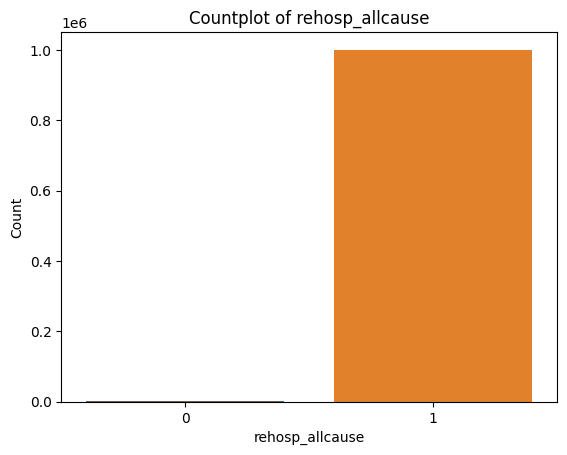

In [46]:
sns.countplot(data=merged_df, x='rehosp_allcause')
plt.xlabel('rehosp_allcause')
plt.ylabel('Count')
plt.title('Countplot of rehosp_allcause')
plt.show()

# Mortality PostHospitalization for Different Windows (30,90,180,365 days)
I need the death df for this

In [60]:
death_df = dd.read_parquet('/content/drive/MyDrive/VCHAMPS - Train Cleaned/death.parquet')
death_df = death_df.compute()

In [61]:
death_df

,Internalpatientid,Age at death,Death date
0,100036,72,2015-01-18 20:49:10
1,100037,75,2008-10-16 15:14:26
2,100045,85,2019-01-26 11:33:52
3,100095,84,2004-08-10 21:49:35
4,10013,68,2007-06-11 00:17:06
...,...,...,...
97279,99827,88,2003-05-13 23:58:55
97280,99842,78,2010-05-25 14:36:27
97281,99847,82,2012-02-20 05:44:33
97282,99872,93,2010-04-18 05:12:36


Merge with inpatient admissions

In [62]:
hospitalizations_df = merged_df
hospitalizations_df

,Internalpatientid,Age at admission,Admission date,Discharge date,Admitting unit service,Discharging unit service,Admitting specialty,Discharging specialty,mortality_inhosp_allcause,Outpatientreferralflag,...,cc Status_MCC,cc Status_NCC,Discharge disposition_Death with autopsy,Discharge disposition_Death without autopsy,Discharge disposition_Irregular,Discharge disposition_NBC or while ASIH,Discharge disposition_Regular,Discharge disposition_Transfer,Encounter ID,rehosp_allcause
0,10,66,2015-11-28 17:41:09,2015-11-29 01:43:14,NON-COUNT,NON-COUNT,DRUG DEPENDENCE TRMT UNIT,MEDICAL OBSERVATION,0,0,...,1,0,0,0,0,0,1,0,974dbd04-1e56-59c6-a720-b8784dc604b2,1
1,10,66,2015-11-28 17:41:09,2015-11-29 01:43:14,NON-COUNT,NON-COUNT,DRUG DEPENDENCE TRMT UNIT,MEDICAL OBSERVATION,0,0,...,0,1,0,0,0,0,1,0,974dbd04-1e56-59c6-a720-b8784dc604b2,1
2,100001,84,2009-10-01 21:19:50,2009-10-04 16:51:33,MEDICINE,MEDICINE,PSYCHIATRIC MENTALLY INFIRM,GENERAL(ACUTE MEDICINE),0,1,...,1,0,0,0,0,0,1,0,c86658fc-cb34-536f-bf7c-a6a05ad131cc,1
3,100001,84,2009-10-01 21:19:50,2009-10-04 16:51:33,MEDICINE,MEDICINE,PSYCHIATRIC MENTALLY INFIRM,GENERAL(ACUTE MEDICINE),0,1,...,0,1,0,0,0,0,1,0,c86658fc-cb34-536f-bf7c-a6a05ad131cc,1
4,100001,85,2010-11-10 04:32:39,2010-11-19 08:49:45,SURGERY,SURGERY,SUBSTANCE ABUSE RES TRMT PROG,ORTHOPEDIC,0,0,...,0,1,0,0,0,0,1,0,9b0880c7-906a-5869-9bbb-698c6183bdec,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001358,99975,89,2018-01-05 00:59:05,2018-01-06 23:18:39,NON-COUNT,NON-COUNT,PODIATRY,MEDICAL OBSERVATION,0,0,...,0,1,0,0,0,0,1,0,95223157-498c-5de5-a061-13d1e9ae985a,1
1001359,99986,73,2019-06-26 19:47:10,2019-06-29 21:18:00,MEDICINE,MEDICINE,INTERMEDIATE MEDICINE,GENERAL(ACUTE MEDICINE),0,1,...,0,1,0,0,0,0,1,0,bd343752-5059-5181-81ad-dd066c9179c3,1
1001360,99986,73,2019-06-26 19:47:10,2019-06-29 21:18:00,MEDICINE,MEDICINE,INTERMEDIATE MEDICINE,GENERAL(ACUTE MEDICINE),0,1,...,0,1,0,0,0,0,1,0,bd343752-5059-5181-81ad-dd066c9179c3,1
1001361,99994,83,2016-08-13 20:09:52,2016-08-15 16:43:07,SURGERY,MEDICINE,INTERMEDIATE MEDICINE,GENERAL(ACUTE MEDICINE),0,1,...,0,0,0,0,0,0,1,0,a0b6452b-5012-5b06-81f3-150b3a92b656,1


In [64]:
merged_df = hospitalizations_df.merge(death_df, on='Internalpatientid', how='left')
merged_df

,Internalpatientid,Age at admission,Admission date,Discharge date,Admitting unit service,Discharging unit service,Admitting specialty,Discharging specialty,mortality_inhosp_allcause,Outpatientreferralflag,...,Discharge disposition_Death with autopsy,Discharge disposition_Death without autopsy,Discharge disposition_Irregular,Discharge disposition_NBC or while ASIH,Discharge disposition_Regular,Discharge disposition_Transfer,Encounter ID,rehosp_allcause,Age at death,Death date
0,10,66,2015-11-28 17:41:09,2015-11-29 01:43:14,NON-COUNT,NON-COUNT,DRUG DEPENDENCE TRMT UNIT,MEDICAL OBSERVATION,0,0,...,0,0,0,0,1,0,974dbd04-1e56-59c6-a720-b8784dc604b2,1,72.0,2022-08-25 14:16:51
1,10,66,2015-11-28 17:41:09,2015-11-29 01:43:14,NON-COUNT,NON-COUNT,DRUG DEPENDENCE TRMT UNIT,MEDICAL OBSERVATION,0,0,...,0,0,0,0,1,0,974dbd04-1e56-59c6-a720-b8784dc604b2,1,72.0,2022-08-25 14:16:51
2,100001,84,2009-10-01 21:19:50,2009-10-04 16:51:33,MEDICINE,MEDICINE,PSYCHIATRIC MENTALLY INFIRM,GENERAL(ACUTE MEDICINE),0,1,...,0,0,0,0,1,0,c86658fc-cb34-536f-bf7c-a6a05ad131cc,1,89.0,2014-12-19 20:33:04
3,100001,84,2009-10-01 21:19:50,2009-10-04 16:51:33,MEDICINE,MEDICINE,PSYCHIATRIC MENTALLY INFIRM,GENERAL(ACUTE MEDICINE),0,1,...,0,0,0,0,1,0,c86658fc-cb34-536f-bf7c-a6a05ad131cc,1,89.0,2014-12-19 20:33:04
4,100001,85,2010-11-10 04:32:39,2010-11-19 08:49:45,SURGERY,SURGERY,SUBSTANCE ABUSE RES TRMT PROG,ORTHOPEDIC,0,0,...,0,0,0,0,1,0,9b0880c7-906a-5869-9bbb-698c6183bdec,1,89.0,2014-12-19 20:33:04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001358,99975,89,2018-01-05 00:59:05,2018-01-06 23:18:39,NON-COUNT,NON-COUNT,PODIATRY,MEDICAL OBSERVATION,0,0,...,0,0,0,0,1,0,95223157-498c-5de5-a061-13d1e9ae985a,1,94.0,2023-09-05 00:31:01
1001359,99986,73,2019-06-26 19:47:10,2019-06-29 21:18:00,MEDICINE,MEDICINE,INTERMEDIATE MEDICINE,GENERAL(ACUTE MEDICINE),0,1,...,0,0,0,0,1,0,bd343752-5059-5181-81ad-dd066c9179c3,1,75.0,2021-03-23 01:31:35
1001360,99986,73,2019-06-26 19:47:10,2019-06-29 21:18:00,MEDICINE,MEDICINE,INTERMEDIATE MEDICINE,GENERAL(ACUTE MEDICINE),0,1,...,0,0,0,0,1,0,bd343752-5059-5181-81ad-dd066c9179c3,1,75.0,2021-03-23 01:31:35
1001361,99994,83,2016-08-13 20:09:52,2016-08-15 16:43:07,SURGERY,MEDICINE,INTERMEDIATE MEDICINE,GENERAL(ACUTE MEDICINE),0,1,...,0,0,0,0,1,0,a0b6452b-5012-5b06-81f3-150b3a92b656,1,87.0,2020-05-02 14:52:17


In [67]:
merged_df['mortality_posthosp_30d'] = ((merged_df['mortality_inhosp_allcause'] == 0) & ((merged_df['Death date'] - merged_df['Discharge date']).dt.days < 30)).astype(int)
merged_df['mortality_posthosp_90d'] = ((merged_df['mortality_inhosp_allcause'] == 0) & ((merged_df['Death date'] - merged_df['Discharge date']).dt.days < 90)).astype(int)
merged_df['mortality_posthosp_180d'] = ((merged_df['mortality_inhosp_allcause'] == 0) & ((merged_df['Death date'] - merged_df['Discharge date']).dt.days < 180)).astype(int)
merged_df['mortality_posthosp_365d'] = ((merged_df['mortality_inhosp_allcause'] == 0) & ((merged_df['Death date'] - merged_df['Discharge date']).dt.days < 365)).astype(int)
merged_df

,Internalpatientid,Age at admission,Admission date,Discharge date,Admitting unit service,Discharging unit service,Admitting specialty,Discharging specialty,mortality_inhosp_allcause,Outpatientreferralflag,...,Discharge disposition_Regular,Discharge disposition_Transfer,Encounter ID,rehosp_allcause,Age at death,Death date,mortality_posthosp_30d,mortality_posthosp_90d,mortality_posthosp_180d,mortality_posthosp_365d
0,10,66,2015-11-28 17:41:09,2015-11-29 01:43:14,NON-COUNT,NON-COUNT,DRUG DEPENDENCE TRMT UNIT,MEDICAL OBSERVATION,0,0,...,1,0,974dbd04-1e56-59c6-a720-b8784dc604b2,1,72.0,2022-08-25 14:16:51,0,0,0,0
1,10,66,2015-11-28 17:41:09,2015-11-29 01:43:14,NON-COUNT,NON-COUNT,DRUG DEPENDENCE TRMT UNIT,MEDICAL OBSERVATION,0,0,...,1,0,974dbd04-1e56-59c6-a720-b8784dc604b2,1,72.0,2022-08-25 14:16:51,0,0,0,0
2,100001,84,2009-10-01 21:19:50,2009-10-04 16:51:33,MEDICINE,MEDICINE,PSYCHIATRIC MENTALLY INFIRM,GENERAL(ACUTE MEDICINE),0,1,...,1,0,c86658fc-cb34-536f-bf7c-a6a05ad131cc,1,89.0,2014-12-19 20:33:04,0,0,0,0
3,100001,84,2009-10-01 21:19:50,2009-10-04 16:51:33,MEDICINE,MEDICINE,PSYCHIATRIC MENTALLY INFIRM,GENERAL(ACUTE MEDICINE),0,1,...,1,0,c86658fc-cb34-536f-bf7c-a6a05ad131cc,1,89.0,2014-12-19 20:33:04,0,0,0,0
4,100001,85,2010-11-10 04:32:39,2010-11-19 08:49:45,SURGERY,SURGERY,SUBSTANCE ABUSE RES TRMT PROG,ORTHOPEDIC,0,0,...,1,0,9b0880c7-906a-5869-9bbb-698c6183bdec,1,89.0,2014-12-19 20:33:04,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001358,99975,89,2018-01-05 00:59:05,2018-01-06 23:18:39,NON-COUNT,NON-COUNT,PODIATRY,MEDICAL OBSERVATION,0,0,...,1,0,95223157-498c-5de5-a061-13d1e9ae985a,1,94.0,2023-09-05 00:31:01,0,0,0,0
1001359,99986,73,2019-06-26 19:47:10,2019-06-29 21:18:00,MEDICINE,MEDICINE,INTERMEDIATE MEDICINE,GENERAL(ACUTE MEDICINE),0,1,...,1,0,bd343752-5059-5181-81ad-dd066c9179c3,1,75.0,2021-03-23 01:31:35,0,0,0,0
1001360,99986,73,2019-06-26 19:47:10,2019-06-29 21:18:00,MEDICINE,MEDICINE,INTERMEDIATE MEDICINE,GENERAL(ACUTE MEDICINE),0,1,...,1,0,bd343752-5059-5181-81ad-dd066c9179c3,1,75.0,2021-03-23 01:31:35,0,0,0,0
1001361,99994,83,2016-08-13 20:09:52,2016-08-15 16:43:07,SURGERY,MEDICINE,INTERMEDIATE MEDICINE,GENERAL(ACUTE MEDICINE),0,1,...,1,0,a0b6452b-5012-5b06-81f3-150b3a92b656,1,87.0,2020-05-02 14:52:17,0,0,0,0


In [68]:
hospitalization_df = merged_df
hospitalization_df

,Internalpatientid,Age at admission,Admission date,Discharge date,Admitting unit service,Discharging unit service,Admitting specialty,Discharging specialty,mortality_inhosp_allcause,Outpatientreferralflag,...,Discharge disposition_Regular,Discharge disposition_Transfer,Encounter ID,rehosp_allcause,Age at death,Death date,mortality_posthosp_30d,mortality_posthosp_90d,mortality_posthosp_180d,mortality_posthosp_365d
0,10,66,2015-11-28 17:41:09,2015-11-29 01:43:14,NON-COUNT,NON-COUNT,DRUG DEPENDENCE TRMT UNIT,MEDICAL OBSERVATION,0,0,...,1,0,974dbd04-1e56-59c6-a720-b8784dc604b2,1,72.0,2022-08-25 14:16:51,0,0,0,0
1,10,66,2015-11-28 17:41:09,2015-11-29 01:43:14,NON-COUNT,NON-COUNT,DRUG DEPENDENCE TRMT UNIT,MEDICAL OBSERVATION,0,0,...,1,0,974dbd04-1e56-59c6-a720-b8784dc604b2,1,72.0,2022-08-25 14:16:51,0,0,0,0
2,100001,84,2009-10-01 21:19:50,2009-10-04 16:51:33,MEDICINE,MEDICINE,PSYCHIATRIC MENTALLY INFIRM,GENERAL(ACUTE MEDICINE),0,1,...,1,0,c86658fc-cb34-536f-bf7c-a6a05ad131cc,1,89.0,2014-12-19 20:33:04,0,0,0,0
3,100001,84,2009-10-01 21:19:50,2009-10-04 16:51:33,MEDICINE,MEDICINE,PSYCHIATRIC MENTALLY INFIRM,GENERAL(ACUTE MEDICINE),0,1,...,1,0,c86658fc-cb34-536f-bf7c-a6a05ad131cc,1,89.0,2014-12-19 20:33:04,0,0,0,0
4,100001,85,2010-11-10 04:32:39,2010-11-19 08:49:45,SURGERY,SURGERY,SUBSTANCE ABUSE RES TRMT PROG,ORTHOPEDIC,0,0,...,1,0,9b0880c7-906a-5869-9bbb-698c6183bdec,1,89.0,2014-12-19 20:33:04,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001358,99975,89,2018-01-05 00:59:05,2018-01-06 23:18:39,NON-COUNT,NON-COUNT,PODIATRY,MEDICAL OBSERVATION,0,0,...,1,0,95223157-498c-5de5-a061-13d1e9ae985a,1,94.0,2023-09-05 00:31:01,0,0,0,0
1001359,99986,73,2019-06-26 19:47:10,2019-06-29 21:18:00,MEDICINE,MEDICINE,INTERMEDIATE MEDICINE,GENERAL(ACUTE MEDICINE),0,1,...,1,0,bd343752-5059-5181-81ad-dd066c9179c3,1,75.0,2021-03-23 01:31:35,0,0,0,0
1001360,99986,73,2019-06-26 19:47:10,2019-06-29 21:18:00,MEDICINE,MEDICINE,INTERMEDIATE MEDICINE,GENERAL(ACUTE MEDICINE),0,1,...,1,0,bd343752-5059-5181-81ad-dd066c9179c3,1,75.0,2021-03-23 01:31:35,0,0,0,0
1001361,99994,83,2016-08-13 20:09:52,2016-08-15 16:43:07,SURGERY,MEDICINE,INTERMEDIATE MEDICINE,GENERAL(ACUTE MEDICINE),0,1,...,1,0,a0b6452b-5012-5b06-81f3-150b3a92b656,1,87.0,2020-05-02 14:52:17,0,0,0,0


In [69]:
hospitalization_df.columns

Index(['Internalpatientid', 'Age at admission', 'Admission date',
       'Discharge date', 'Admitting unit service', 'Discharging unit service',
       'Admitting specialty', 'Discharging specialty',
       'mortality_inhosp_allcause', 'Outpatientreferralflag',
       'Agentorangeflag', 'CV diagnosis', 'diagnosis', 'code', 'cc Status_CC',
       'cc Status_MCC', 'cc Status_NCC',
       'Discharge disposition_Death with autopsy',
       'Discharge disposition_Death without autopsy',
       'Discharge disposition_Irregular',
       'Discharge disposition_NBC or while ASIH',
       'Discharge disposition_Regular', 'Discharge disposition_Transfer',
       'Encounter ID', 'rehosp_allcause', 'Age at death', 'Death date',
       'mortality_posthosp_30d', 'mortality_posthosp_90d',
       'mortality_posthosp_180d', 'mortality_posthosp_365d'],
      dtype='object')

# All Cause Readmission

In [89]:
grouped_df = hospitalizations_df.groupby(['Internalpatientid', 'Admission date', 'Discharge date']).size().reset_index(name='Count')
grouped_df

,Internalpatientid,Admission date,Discharge date,Count
0,1,2011-12-10 18:28:02,2011-12-14 18:23:17,2
1,1,2012-08-10 23:27:47,2012-08-14 20:57:06,2
2,1,2016-07-16 15:18:16,2016-07-22 21:36:24,2
3,1,2022-12-31 05:41:51,2023-01-01 23:06:30,2
4,2,2009-09-30 11:42:00,2009-10-01 06:33:38,2
...,...,...,...,...
494373,169062,2005-02-24 11:52:16,2005-03-17 07:14:14,2
494374,169062,2005-03-17 06:48:07,2005-04-29 10:02:03,2
494375,169062,2005-05-17 11:24:53,2005-05-19 03:28:31,2
494376,169062,2005-06-01 02:09:21,2005-06-04 03:34:07,2


In [95]:
# Sort the DataFrame by Internalpatientid and Admission date
grouped_df = grouped_df.sort_values(['Internalpatientid', 'Admission date'])

# Create a new column Prev_Discharge with the previous row's Discharge date
grouped_df['Prev_Discharge'] = grouped_df.groupby('Internalpatientid')['Discharge date'].shift()

# Calculate the time difference between Prev_Discharge and Admission date
grouped_df['Time_Passed'] = (grouped_df['Admission date'] - grouped_df['Prev_Discharge']).dt.days

# Drop rows with NaN and NaT values in the Time_Passed column
grouped_df = grouped_df.dropna(subset=['Time_Passed'])

# Drop rows with Time_Passed equal to -1
grouped_df = grouped_df[grouped_df['Time_Passed'] != -1]

# Convert Time_Passed column to integer (days)
grouped_df['Time_Passed'] = grouped_df['Time_Passed'].astype(int)

grouped_df

,Internalpatientid,Admission date,Discharge date,Count,Prev_Discharge,Time_Passed
2,1,2016-07-16 15:18:16,2016-07-22 21:36:24,2,2012-08-14 20:57:06,1431
3,1,2022-12-31 05:41:51,2023-01-01 23:06:30,2,2016-07-22 21:36:24,2352
6,2,2014-06-10 07:59:09,2014-06-11 08:08:04,1,2012-07-10 10:43:20,699
7,2,2018-01-11 19:13:32,2018-01-12 23:41:20,2,2014-06-11 08:08:04,1310
8,2,2018-06-25 14:02:31,2018-06-28 02:33:47,2,2018-01-12 23:41:20,163
...,...,...,...,...,...,...
494370,169062,2002-10-21 10:53:02,2002-10-27 12:31:17,2,2002-10-21 10:27:09,0
494371,169062,2004-08-10 14:07:29,2004-08-11 21:53:50,2,2002-10-27 12:31:17,653
494373,169062,2005-02-24 11:52:16,2005-03-17 07:14:14,2,2004-08-11 21:53:50,196
494375,169062,2005-05-17 11:24:53,2005-05-19 03:28:31,2,2005-03-17 07:14:14,61


In [105]:
smallest_time_passed = grouped_df.groupby('Internalpatientid')['Time_Passed'].min()
smallest_time_passed_df = smallest_time_passed.reset_index(name='Smallest Time Passed')
smallest_time_passed_df

,Internalpatientid,Smallest Time Passed
0,1,1431
1,2,0
2,11,0
3,13,545
4,15,307
...,...,...
53080,169050,1841
53081,169053,5
53082,169057,0
53083,169060,18


In [106]:
smallest_time_passed_df['Smallest Time Passed'].value_counts()

0       14922
1        1510
2        1376
3        1249
4        1160
        ...  
4950        1
2365        1
6051        1
1814        1
3813        1
Name: Smallest Time Passed, Length: 3142, dtype: int64

In [108]:
smallest_time_passed_df['readmit_allcause_30d'] = np.where(smallest_time_passed_df['Smallest Time Passed'] < 30, 1, 0)
smallest_time_passed_df['readmit_allcause_90d'] = np.where(smallest_time_passed_df['Smallest Time Passed'] < 90, 1, 0)
smallest_time_passed_df['readmit_allcause_180d'] = np.where(smallest_time_passed_df['Smallest Time Passed'] < 180, 1, 0)
smallest_time_passed_df['readmit_allcause_365d'] = np.where(smallest_time_passed_df['Smallest Time Passed'] < 365, 1, 0)
smallest_time_passed_df

,Internalpatientid,Smallest Time Passed,readmit_allcause_30d,readmit_allcause_90d,readmit_allcause_180d,readmit_allcause_365d
0,1,1431,0,0,0,0
1,2,0,1,1,1,1
2,11,0,1,1,1,1
3,13,545,0,0,0,0
4,15,307,0,0,0,1
...,...,...,...,...,...,...
53080,169050,1841,0,0,0,0
53081,169053,5,1,1,1,1
53082,169057,0,1,1,1,1
53083,169060,18,1,1,1,1


In [109]:
merged_df = hospitalizations_df.merge(smallest_time_passed_df, on='Internalpatientid', how='left')
merged_df

,Internalpatientid,Age at admission,Admission date,Discharge date,Admitting unit service,Discharging unit service,Admitting specialty,Discharging specialty,mortality_inhosp_allcause,Outpatientreferralflag,...,Discharge disposition_NBC or while ASIH,Discharge disposition_Regular,Discharge disposition_Transfer,Encounter ID,rehosp_allcause,Smallest Time Passed,readmit_allcause_30d,readmit_allcause_90d,readmit_allcause_180d,readmit_allcause_365d
0,10,66,2015-11-28 17:41:09,2015-11-29 01:43:14,NON-COUNT,NON-COUNT,DRUG DEPENDENCE TRMT UNIT,MEDICAL OBSERVATION,0,0,...,0,1,0,974dbd04-1e56-59c6-a720-b8784dc604b2,1,NaN,NaN,NaN,NaN,NaN
1,10,66,2015-11-28 17:41:09,2015-11-29 01:43:14,NON-COUNT,NON-COUNT,DRUG DEPENDENCE TRMT UNIT,MEDICAL OBSERVATION,0,0,...,0,1,0,974dbd04-1e56-59c6-a720-b8784dc604b2,1,NaN,NaN,NaN,NaN,NaN
2,100001,84,2009-10-01 21:19:50,2009-10-04 16:51:33,MEDICINE,MEDICINE,PSYCHIATRIC MENTALLY INFIRM,GENERAL(ACUTE MEDICINE),0,1,...,0,1,0,c86658fc-cb34-536f-bf7c-a6a05ad131cc,1,63.0,0.0,1.0,1.0,1.0
3,100001,84,2009-10-01 21:19:50,2009-10-04 16:51:33,MEDICINE,MEDICINE,PSYCHIATRIC MENTALLY INFIRM,GENERAL(ACUTE MEDICINE),0,1,...,0,1,0,c86658fc-cb34-536f-bf7c-a6a05ad131cc,1,63.0,0.0,1.0,1.0,1.0
4,100001,85,2010-11-10 04:32:39,2010-11-19 08:49:45,SURGERY,SURGERY,SUBSTANCE ABUSE RES TRMT PROG,ORTHOPEDIC,0,0,...,0,1,0,9b0880c7-906a-5869-9bbb-698c6183bdec,1,63.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001358,99975,89,2018-01-05 00:59:05,2018-01-06 23:18:39,NON-COUNT,NON-COUNT,PODIATRY,MEDICAL OBSERVATION,0,0,...,0,1,0,95223157-498c-5de5-a061-13d1e9ae985a,1,856.0,0.0,0.0,0.0,0.0
1001359,99986,73,2019-06-26 19:47:10,2019-06-29 21:18:00,MEDICINE,MEDICINE,INTERMEDIATE MEDICINE,GENERAL(ACUTE MEDICINE),0,1,...,0,1,0,bd343752-5059-5181-81ad-dd066c9179c3,1,0.0,1.0,1.0,1.0,1.0
1001360,99986,73,2019-06-26 19:47:10,2019-06-29 21:18:00,MEDICINE,MEDICINE,INTERMEDIATE MEDICINE,GENERAL(ACUTE MEDICINE),0,1,...,0,1,0,bd343752-5059-5181-81ad-dd066c9179c3,1,0.0,1.0,1.0,1.0,1.0
1001361,99994,83,2016-08-13 20:09:52,2016-08-15 16:43:07,SURGERY,MEDICINE,INTERMEDIATE MEDICINE,GENERAL(ACUTE MEDICINE),0,1,...,0,1,0,a0b6452b-5012-5b06-81f3-150b3a92b656,1,28.0,1.0,1.0,1.0,1.0


In [110]:
hospitalizations_df = merged_df

# CV Readmissions
This one is easy since I already have the CV diagnosis and the readmission time variables already made

In [111]:
hospitalizations_df['readmit_CV_30d']  = np.where((hospitalizations_df['CV diagnosis'] == 1) & (hospitalizations_df['readmit_allcause_30d'] == 1), 1, 0)
hospitalizations_df['readmit_CV_90d']  = np.where((hospitalizations_df['CV diagnosis'] == 1) & (hospitalizations_df['readmit_allcause_90d'] == 1), 1, 0)
hospitalizations_df['readmit_CV_180d'] = np.where((hospitalizations_df['CV diagnosis'] == 1) & (hospitalizations_df['readmit_allcause_180d'] == 1), 1, 0)
hospitalizations_df['readmit_CV_365d'] = np.where((hospitalizations_df['CV diagnosis'] == 1) & (hospitalizations_df['readmit_allcause_365d'] == 1), 1, 0)

In [112]:
hospitalizations_df

,Internalpatientid,Age at admission,Admission date,Discharge date,Admitting unit service,Discharging unit service,Admitting specialty,Discharging specialty,mortality_inhosp_allcause,Outpatientreferralflag,...,rehosp_allcause,Smallest Time Passed,readmit_allcause_30d,readmit_allcause_90d,readmit_allcause_180d,readmit_allcause_365d,readmit_CV_30d,readmit_CV_90d,readmit_CV_180d,readmit_CV_365d
0,10,66,2015-11-28 17:41:09,2015-11-29 01:43:14,NON-COUNT,NON-COUNT,DRUG DEPENDENCE TRMT UNIT,MEDICAL OBSERVATION,0,0,...,1,NaN,NaN,NaN,NaN,NaN,0,0,0,0
1,10,66,2015-11-28 17:41:09,2015-11-29 01:43:14,NON-COUNT,NON-COUNT,DRUG DEPENDENCE TRMT UNIT,MEDICAL OBSERVATION,0,0,...,1,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2,100001,84,2009-10-01 21:19:50,2009-10-04 16:51:33,MEDICINE,MEDICINE,PSYCHIATRIC MENTALLY INFIRM,GENERAL(ACUTE MEDICINE),0,1,...,1,63.0,0.0,1.0,1.0,1.0,0,0,0,0
3,100001,84,2009-10-01 21:19:50,2009-10-04 16:51:33,MEDICINE,MEDICINE,PSYCHIATRIC MENTALLY INFIRM,GENERAL(ACUTE MEDICINE),0,1,...,1,63.0,0.0,1.0,1.0,1.0,0,0,0,0
4,100001,85,2010-11-10 04:32:39,2010-11-19 08:49:45,SURGERY,SURGERY,SUBSTANCE ABUSE RES TRMT PROG,ORTHOPEDIC,0,0,...,1,63.0,0.0,1.0,1.0,1.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001358,99975,89,2018-01-05 00:59:05,2018-01-06 23:18:39,NON-COUNT,NON-COUNT,PODIATRY,MEDICAL OBSERVATION,0,0,...,1,856.0,0.0,0.0,0.0,0.0,0,0,0,0
1001359,99986,73,2019-06-26 19:47:10,2019-06-29 21:18:00,MEDICINE,MEDICINE,INTERMEDIATE MEDICINE,GENERAL(ACUTE MEDICINE),0,1,...,1,0.0,1.0,1.0,1.0,1.0,0,0,0,0
1001360,99986,73,2019-06-26 19:47:10,2019-06-29 21:18:00,MEDICINE,MEDICINE,INTERMEDIATE MEDICINE,GENERAL(ACUTE MEDICINE),0,1,...,1,0.0,1.0,1.0,1.0,1.0,0,0,0,0
1001361,99994,83,2016-08-13 20:09:52,2016-08-15 16:43:07,SURGERY,MEDICINE,INTERMEDIATE MEDICINE,GENERAL(ACUTE MEDICINE),0,1,...,1,28.0,1.0,1.0,1.0,1.0,0,0,0,0


# CV Inhospital Mortality
Easy one to construct since we have died during admission and cv diagnosis

In [119]:
hospitalizations_df['mortality_inhosp_CV']  = np.where((hospitalizations_df['CV diagnosis'] == 1) & (hospitalizations_df['mortality_inhosp_allcause'] == 1), 1, 0)
hospitalizations_df

,Internalpatientid,Age at admission,Admission date,Discharge date,Admitting unit service,Discharging unit service,Admitting specialty,Discharging specialty,mortality_inhosp_allcause,Outpatientreferralflag,...,Smallest Time Passed,readmit_allcause_30d,readmit_allcause_90d,readmit_allcause_180d,readmit_allcause_365d,readmit_CV_30d,readmit_CV_90d,readmit_CV_180d,readmit_CV_365d,mortality_inhosp_CV
0,10,66,2015-11-28 17:41:09,2015-11-29 01:43:14,NON-COUNT,NON-COUNT,DRUG DEPENDENCE TRMT UNIT,MEDICAL OBSERVATION,0,0,...,NaN,0,0,0,0,0,0,0,0,0
1,10,66,2015-11-28 17:41:09,2015-11-29 01:43:14,NON-COUNT,NON-COUNT,DRUG DEPENDENCE TRMT UNIT,MEDICAL OBSERVATION,0,0,...,NaN,0,0,0,0,0,0,0,0,0
2,100001,84,2009-10-01 21:19:50,2009-10-04 16:51:33,MEDICINE,MEDICINE,PSYCHIATRIC MENTALLY INFIRM,GENERAL(ACUTE MEDICINE),0,1,...,63.0,0,1,1,1,0,0,0,0,0
3,100001,84,2009-10-01 21:19:50,2009-10-04 16:51:33,MEDICINE,MEDICINE,PSYCHIATRIC MENTALLY INFIRM,GENERAL(ACUTE MEDICINE),0,1,...,63.0,0,1,1,1,0,0,0,0,0
4,100001,85,2010-11-10 04:32:39,2010-11-19 08:49:45,SURGERY,SURGERY,SUBSTANCE ABUSE RES TRMT PROG,ORTHOPEDIC,0,0,...,63.0,0,1,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001358,99975,89,2018-01-05 00:59:05,2018-01-06 23:18:39,NON-COUNT,NON-COUNT,PODIATRY,MEDICAL OBSERVATION,0,0,...,856.0,0,0,0,0,0,0,0,0,0
1001359,99986,73,2019-06-26 19:47:10,2019-06-29 21:18:00,MEDICINE,MEDICINE,INTERMEDIATE MEDICINE,GENERAL(ACUTE MEDICINE),0,1,...,0.0,1,1,1,1,0,0,0,0,0
1001360,99986,73,2019-06-26 19:47:10,2019-06-29 21:18:00,MEDICINE,MEDICINE,INTERMEDIATE MEDICINE,GENERAL(ACUTE MEDICINE),0,1,...,0.0,1,1,1,1,0,0,0,0,0
1001361,99994,83,2016-08-13 20:09:52,2016-08-15 16:43:07,SURGERY,MEDICINE,INTERMEDIATE MEDICINE,GENERAL(ACUTE MEDICINE),0,1,...,28.0,1,1,1,1,0,0,0,0,0


In [120]:
hospitalizations_df.dtypes

Internalpatientid                                       int32
Age at admission                                         int8
Admission date                                 datetime64[ns]
Discharge date                                 datetime64[ns]
Admitting unit service                                 object
Discharging unit service                               object
Admitting specialty                                    object
Discharging specialty                                  object
mortality_inhosp_allcause                                int8
Outpatientreferralflag                                   int8
Agentorangeflag                                          int8
CV diagnosis                                             int8
diagnosis                                              object
code                                                   object
cc Status_CC                                            uint8
cc Status_MCC                                           uint8
cc Statu

In [121]:
columns_to_convert = ['readmit_allcause_30d', 'readmit_allcause_90d', 'readmit_allcause_180d', 'readmit_allcause_365d','readmit_CV_30d','readmit_CV_90d','readmit_CV_180d','readmit_CV_365d','rehosp_allcause','mortality_inhosp_CV']
default_value = 0
for column in columns_to_convert:
    hospitalizations_df[column] = hospitalizations_df[column].fillna(default_value).astype('int8')

In [122]:
hospitalizations_df.dtypes

Internalpatientid                                       int32
Age at admission                                         int8
Admission date                                 datetime64[ns]
Discharge date                                 datetime64[ns]
Admitting unit service                                 object
Discharging unit service                               object
Admitting specialty                                    object
Discharging specialty                                  object
mortality_inhosp_allcause                                int8
Outpatientreferralflag                                   int8
Agentorangeflag                                          int8
CV diagnosis                                             int8
diagnosis                                              object
code                                                   object
cc Status_CC                                            uint8
cc Status_MCC                                           uint8
cc Statu